In [1]:
import os
import copy
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Creat datasets and data loaders for image classification purpose

In [2]:
%cd /content/drive/My Drive/CV_Proj/CV21_AnnotatedDataset/augmented_img_2

/content/drive/My Drive/CV_Proj/CV21_AnnotatedDataset/augmented_img_2


In [3]:
strToLabel = {'Chaetomium_Einzelspore_Candidate': 0,'Chaetomium_Agglomerate_Candidate': 1,'Stachybotrys_Einzelspore_Candidate': 2,'Stachybotrys_Agglomerate_Candidate': 3}
labels = [strToLabel['_'.join(t.split('_')[:-1])] for t in os.listdir('./')]

In [4]:
len(labels)

25052

In [5]:
!nvidia-smi

Fri Dec 17 08:29:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class SporeImageClassificationDataset(Dataset):
    """Spore Images for classification dataset."""

    def __init__(self, root_dir, transform=None):
      self.root_dir = root_dir
      self.img_list = os.listdir(self.root_dir)
      self.transform = transform
      self.label_list = ['Chaetomium_Einzelspore_Candidate','Chaetomium_Agglomerate_Candidate','Stachybotrys_Einzelspore_Candidate','Stachybotrys_Agglomerate_Candidate']

    def __len__(self):
      return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.img_list[idx])
        image = Image.open(img_name)
        label = self.label_list.index('_'.join(self.img_list[idx].split('_')[:-1]))


        if self.transform:
            image = self.transform(image)

        return [image, label] 

In [8]:
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [9]:
train_set = SporeImageClassificationDataset('./', data_transform)

# Load pretrained models

## ResNet

In [10]:
resnet50 = models.resnet50(pretrained=True)
ct = 0
for child in resnet50.children():
  ct += 1
  if ct < 10:
    for param in child.parameters():
        param.requires_grad = False

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)
resnet50 = resnet50.cuda()

In [ ]:
resnet101 = models.resnet101(pretrained=True)
ct = 0
for child in resnet101.children():
  ct += 1
  if ct < 10:
      for param in child.parameters():
          param.requires_grad = False

num_ftrs = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_ftrs,4)

In [ ]:
resnet152 = models.resnet152(pretrained=True)
ct = 0
for child in resnet152.children():
  ct += 1
  if ct < 10:
      for param in child.parameters():
          param.requires_grad = False

num_ftrs = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_ftrs,4)

# Training pretrained models

## Training ResNet

In [ ]:
resnet50._modules['layer4'][-1]._modules['conv3']

In [ ]:
def reset_weights(m):
  for child in m.children():
    does_grad = False
    for param in child.parameters():
      if param.requires_grad == True:
        does_grad = True
        break
    if hasattr(child, 'reset_parameters') and does_grad:
      print(f'Reset trainable parameters of layer = {child}')
      child.reset_parameters()

In [ ]:
k_folds = 5
num_epochs = 5
loss_function = nn.CrossEntropyLoss()

results = {}

torch.manual_seed(42)

kfold = KFold(n_splits=k_folds, shuffle=True)
  
print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_set)):
  
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=64, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    train_set,
                    batch_size=128, sampler=test_subsampler)
  
  resnet50.apply(reset_weights)
  
  optimizer = torch.optim.Adam(resnet50.parameters(), lr=5e-4)
  
  for epoch in range(0, num_epochs):

    print(f'Starting epoch {epoch+1}')

    current_loss = 0.0

    print(len(trainloader), len(testloader))

    for i, data in enumerate(trainloader, 0):
      
      inputs, targets = data
      optimizer.zero_grad()
      
      outputs = resnet50(inputs)

      loss = loss_function(outputs, targets)
      loss.backward()
      
      optimizer.step()
      
      current_loss += loss.item()
      if i % 5 == 4:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 5))
          current_loss = 0.0

          
  print('Training process has finished. Saving trained model.')

  print('Starting testing')
  
  save_path = f'../resnet50-fold-{fold}.pth'
  torch.save(resnet50.state_dict(), save_path)

  correct, total = 0, 0
  with torch.no_grad():

    for i, data in enumerate(testloader, 0):

      inputs, targets = data

      outputs = resnet50(inputs)

      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)
  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=2048, out_features=4, bias=True)
Starting epoch 1
30 4


KeyboardInterrupt: ignored

In [11]:
torch.manual_seed(42)

class_sample_count = np.array(
    [labels.count(t) for t in np.unique(labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])
samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=8, sampler=sampler, num_workers=8)

optimizer = torch.optim.SGD(resnet50.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
loss_function = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(0, num_epochs):

  print(f'Starting epoch {epoch+1}')

  current_loss = 0.0
  current_acc = 0.0
  current_acc_0 = 0.0
  current_acc_1 = 0.0
  current_acc_2 = 0.0
  current_acc_3 = 0.0

  print(len(trainloader))
  for i, data in enumerate(trainloader, 0):
    
    inputs, targets = data
    optimizer.zero_grad()
    
    outputs = resnet50(inputs.cuda())

    # print(targets)
    # print(torch.max(outputs, 1)[1])
    loss = loss_function(outputs, targets.cuda())
    loss.backward()
    optimizer.step()
    
    current_loss += loss.item()

    with torch.no_grad():
      current_acc += sum(targets == torch.argmax(outputs.cpu(), dim=1)) / len(targets)
      current_acc_0 += sum(torch.argmax(outputs.cpu(), dim=1)[torch.argmax(outputs.cpu(), dim=1) == targets] == 0) / (len(targets[targets == 0]) + 1e-5)
      current_acc_1 += sum(torch.argmax(outputs.cpu(), dim=1)[torch.argmax(outputs.cpu(), dim=1)  == targets] == 1) / (len(targets[targets == 1])+ 1e-5)
      current_acc_2 += sum(torch.argmax(outputs.cpu(), dim=1)[torch.argmax(outputs.cpu(), dim=1)  == targets] == 2) / (len(targets[targets == 2])+ 1e-5)
      current_acc_3 += sum(torch.argmax(outputs.cpu(), dim=1)[torch.argmax(outputs.cpu(), dim=1)  == targets] == 3) / (len(targets[targets == 3])+ 1e-5)

    if i % 5 == 4:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss / 5))
        
        print('Accuracy after mini-batch %5d: %.3f' %
              (i + 1, current_acc / 5))
        print('Accuracy for class 0 after mini-batch %5d: %.3f' %
              (i + 1, current_acc_0 / 5))
        print('Accuracy for class 1 after mini-batch %5d: %.3f' %
              (i + 1, current_acc_1 / 5))
        print('Accuracy for class 2 after mini-batch %5d: %.3f' %
              (i + 1, current_acc_2 / 5))
        print('Accuracy for class 3 after mini-batch %5d: %.3f' %
              (i + 1, current_acc_3 / 5))

        current_loss = 0.0
        current_acc = 0.0
        current_acc_0 = 0.0
        current_acc_1 = 0.0
        current_acc_2 = 0.0
        current_acc_3 = 0.0

print('Training process has finished. Saving trained model.')

save_path = f'../resnet50.pth'
torch.save(resnet50.state_dict(), save_path)

Streaming output truncated to the last 5000 lines.
Accuracy after mini-batch  2100: 0.600
Accuracy for class 0 after mini-batch  2100: 0.000
Accuracy for class 1 after mini-batch  2100: 0.900
Accuracy for class 2 after mini-batch  2100: 0.433
Accuracy for class 3 after mini-batch  2100: 0.533
Loss after mini-batch  2105: 1.177
Accuracy after mini-batch  2105: 0.450
Accuracy for class 0 after mini-batch  2105: 0.413
Accuracy for class 1 after mini-batch  2105: 0.500
Accuracy for class 2 after mini-batch  2105: 0.467
Accuracy for class 3 after mini-batch  2105: 0.550
Loss after mini-batch  2110: 1.255
Accuracy after mini-batch  2110: 0.500
Accuracy for class 0 after mini-batch  2110: 1.000
Accuracy for class 1 after mini-batch  2110: 0.200
Accuracy for class 2 after mini-batch  2110: 0.367
Accuracy for class 3 after mini-batch  2110: 0.567
Loss after mini-batch  2115: 1.057
Accuracy after mini-batch  2115: 0.575
Accuracy for class 0 after mini-batch  2115: 0.467
Accuracy for class 1 afte

# Reporting training statistics

## ResNet50

In [7]:
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

train_set = SporeImageClassificationDataset('./', data_transform)

In [8]:
trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=8)

In [11]:
PATH = "../resnet50.pth"
checkpoint = torch.load(PATH)
resnet50.load_state_dict(checkpoint)
resnet50 = resnet50.cuda()

In [12]:
pred_labels = []
labels = []
for i, data in enumerate(trainloader, 0):
  print(i/len(trainloader)*100,'%')
  d, label = data
  with torch.no_grad():
    _, predicted = torch.max(resnet50(d.reshape(*d.shape).cuda()).data, 1)
    pred_labels.append(predicted)
    labels.append(label)


0.0 %
0.031928480204342274 %
0.06385696040868455 %
0.09578544061302681 %
0.1277139208173691 %
0.15964240102171137 %
0.19157088122605362 %
0.2234993614303959 %
0.2554278416347382 %
0.28735632183908044 %
0.31928480204342274 %
0.351213282247765 %
0.38314176245210724 %
0.41507024265644954 %
0.4469987228607918 %
0.4789272030651341 %
0.5108556832694764 %
0.5427841634738186 %
0.5747126436781609 %
0.6066411238825031 %
0.6385696040868455 %
0.6704980842911877 %
0.70242656449553 %
0.7343550446998722 %
0.7662835249042145 %
0.7982120051085568 %
0.8301404853128991 %
0.8620689655172413 %
0.8939974457215836 %
0.9259259259259258 %
0.9578544061302682 %
0.9897828863346105 %
1.0217113665389528 %
1.053639846743295 %
1.0855683269476373 %
1.1174968071519795 %
1.1494252873563218 %
1.181353767560664 %
1.2132822477650063 %
1.2452107279693485 %
1.277139208173691 %
1.3090676883780332 %
1.3409961685823755 %
1.3729246487867177 %
1.40485312899106 %
1.4367816091954022 %
1.4687100893997445 %
1.5006385696040867 %
1.532

In [13]:
pred_labels = [pred.data.cpu().numpy() for pred in pred_labels]
pred_labels = [p for pred in pred_labels for p in pred]

In [14]:
labels = [l for label in labels for l in label]

In [15]:
pred_labels.count(1)

3850

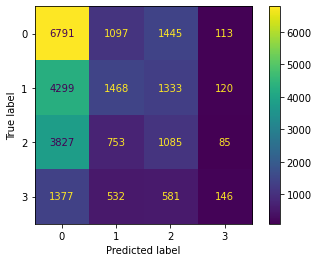

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(labels, pred_labels)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [17]:
target_names = ['Chaetomium_Einzelspore_Candidate','Chaetomium_Agglomerate_Candidate','Stachybotrys_Einzelspore_Candidate','Stachybotrys_Agglomerate_Candidate']
print(classification_report(labels, pred_labels, target_names=target_names))

                                    precision    recall  f1-score   support

  Chaetomium_Einzelspore_Candidate       0.42      0.72      0.53      9446
  Chaetomium_Agglomerate_Candidate       0.38      0.20      0.27      7220
Stachybotrys_Einzelspore_Candidate       0.24      0.19      0.21      5750
Stachybotrys_Agglomerate_Candidate       0.31      0.06      0.09      2636

                          accuracy                           0.38     25052
                         macro avg       0.34      0.29      0.27     25052
                      weighted avg       0.36      0.38      0.33     25052

